In [16]:
__author__ = "Alireza Sadabadi"
__copyright__ = "Copyright (c) 2024 Alireza Sadabadi. All rights reserved."
__credits__ = ["Alireza Sadabadi"]
__license__ = "Apache"
__version__ = "2.0"
__maintainer__ = "Alireza Sadabadi"
__email__ = "alirezasadabady@gmail.com"
__status__ = "Test"
__doc__ = "you can see the tutorials in https://youtube.com/@alirezasadabadi?si=d8o7LK_Ai1Hf68is"

import pandas as pd
import numpy as np
import pandas_ta as pdta
from Meta import *

if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

df = Meta.GetRates(symbol='CARDANO', number_of_data=10000, timeFrame=mt5.TIMEFRAME_H4)
df.to_csv("Candles.csv")

lags = 3
for lag in range(1 , lags + 1):
    colLow = "low-{}".format(lag)
    colHigh = "high-{}".format(lag)
    df[colLow] = df.low.shift(lag)
    df[colHigh] = df.high.shift(lag)
df.dropna(inplace = True)
df.loc[:,['low','low-1','low-2','low-3']]

,low,low-1,low-2,low-3
time,,,,
2021-09-17 00:00:00,2.3900,2.3800,2.3900,2.4600
2021-09-17 04:00:00,2.4000,2.3900,2.3800,2.3900
2021-09-17 08:00:00,2.3900,2.4000,2.3900,2.3800
2021-09-17 12:00:00,2.3300,2.3900,2.4000,2.3900
2021-09-17 16:00:00,2.3400,2.3300,2.3900,2.4000
...,...,...,...,...
2025-02-18 16:00:00,0.7349,0.7686,0.7658,0.7866
2025-02-18 20:00:00,0.7381,0.7349,0.7686,0.7658
2025-02-19 00:00:00,0.7398,0.7381,0.7349,0.7686


In [18]:
buy1 = df['high'] > df['high-1']
buy2 = df['high-1'] > df['low']
buy3 = df['low'] > df['high-2']
buy4 = df['high-2'] > df['low-1']
buy5 = df['low-1'] > df['high-3']
buy6 = df['high-3'] > df['low-2']
buy7 = df['low-2'] > df['low-3']

buy = buy1 & buy2 & buy3 & buy4 & buy5 & buy6 & buy7

sell1 = df['low'] < df['low-1']
sell2 = df['low-1'] < df['high']
sell3 = df['high'] < df['low-2']
sell4 = df['low-2'] < df['high-1']
sell5 = df['high-1'] < df['low-3']
sell6 = df['low-3'] < df['high-2']
sell7 = df['high-2'] < df['high-3']

sell = sell1 & sell2 & sell3 & sell4 & sell5 & sell6 & sell7

df["position"]= np.where(buy, 1, np.nan)
df["position"]= np.where(sell, -1, df.position)
df[df.position == -1].count()

open           76
high           76
low            76
close          76
tick_volume    76
spread         76
real_volume    76
low-1          76
high-1         76
low-2          76
high-2         76
low-3          76
high-3         76
position       76
dtype: int64

In [19]:
df = df.loc[:,["open", "high", "low", "close", "tick_volume", "position"]]
df.reset_index(inplace=True)
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume', 'signal']
df.index = pd.DatetimeIndex(df['Local time'])

def RiskReward(price, buy=True, risk=1, reward=2):  
    leverage = 1
    nb_decimal = str(price)[::-1].find(".")+2
    varDown = risk/leverage
    varUp = reward/leverage

    if buy:
        price_varDown = varDown * price
        price_varUp = varUp * price        
        tp = np.round(price + price_varUp, nb_decimal)
        sl = np.round(price - price_varDown, nb_decimal)            
    else:                
        price_varDown = varDown * price
        price_varUp = varUp * price        
        tp = np.round(price - price_varUp, nb_decimal)
        sl = np.round(price + price_varDown, nb_decimal)
    return tp, sl

def Signal():
    return df.signal

from backtesting import Strategy

class MyStrategy(Strategy):  
    slPct=0.02
    tpPct=0.09
    def init(self):
        super().init()
        self.signal1 = self.I(Signal)

    def next(self):
        super().next() 
                        
        if self.signal1==1 and len(self.trades) == 0:
            tp, sl = RiskReward(self.data.Close[-1], buy=True, risk=self.slPct, reward=self.tpPct)
            self.buy(sl=sl, tp=tp, size=0.1)
        elif self.signal1==-1 and len(self.trades) == 0:
            tp, sl = RiskReward(price=self.data.Close[-1], buy=False, risk=self.slPct, reward=self.tpPct)
            self.sell(sl=sl, tp=tp, size=0.1)

In [22]:
from backtesting import Backtest

backtest = Backtest(df, MyStrategy, cash=100, commission=0.0, margin = 1/5)
result, heatmap = backtest.optimize(slPct=[i/100 for i in range(1, 10)],
                                 tpPct=[i/100 for i in range(1, 10)],
                    maximize='Return [%]', max_tries=3000,
                        random_state=0,
                        return_heatmap=True)
result

Start                     2021-09-17 00:00:00
End                       2025-02-19 08:00:00
Duration                   1251 days 08:00:00
Exposure Time [%]                    39.34955
Equity Final [$]                    294.24336
Equity Peak [$]                     332.17452
Return [%]                          194.24336
Buy & Hold Return [%]               -68.59336
Return (Ann.) [%]                     37.3232
Volatility (Ann.) [%]                30.36795
CAGR [%]                             36.99872
Sharpe Ratio                          1.22903
Sortino Ratio                         2.67617
Calmar Ratio                          1.89483
Max. Drawdown [%]                   -19.69743
Avg. Drawdown [%]                    -2.76774
Max. Drawdown Duration      234 days 20:00:00
Avg. Drawdown Duration       12 days 07:00:00
# Trades                                   94
Win Rate [%]                         63.82979
Best Trade [%]                        9.58415
Worst Trade [%]                   

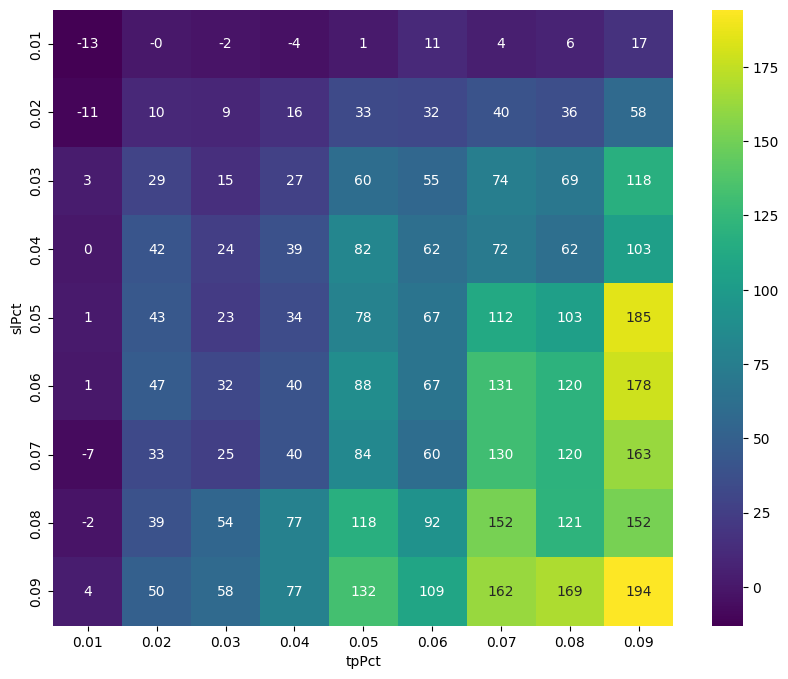

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert multiindex series to dataframe

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap.unstack(), annot=True, cmap='viridis', fmt='.0f')
plt.show()